# CPED 関数のパフォーマンス比較

このノートブックでは、`cped` (Copy & Paste Edit Distance) 関数のバックエンド実装のパフォーマンスを比較します。

1.  **Python版**: `cped(backend='python')`
2.  **C++版**: `cped(backend='cpp')`

比較を通じて、各実装の特性と、どのような状況でどの実装が有効であるかを明らかにします。

## 1. セットアップ

必要なライブラリと、`src`ディレクトリからCPED関数をインポートします。

In [1]:
import sys
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random

# Add src directory to path to import cped module
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from repmetric import cped, cped_matrix, bicped, bicped_matrix, CPP_AVAILABLE
from repmetric.util import generate_test_case

# Set random seed for reproducibility
random.seed(42)

# Matplotlibの日本語設定
try:
    import japanize_matplotlib

    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams["font.family"] = "sans-serif"

## 2. テストデータの生成

パフォーマンス測定のために、複雑さが異なるいくつかのテスト用文字列ペアを生成します。

### 再現性のための注意点

公平なパフォーマンス比較のため、このノートブックでは乱数シードを`42`に固定しています。

乱数は以下の順番で使用されます：
1. **ベンチマーク1用データ**: `generate_test_case` を3回呼び出し、'small', 'medium', 'large' のテストケースを生成します。
2. **ベンチマーク2用データ**: `generate_test_case` を `num_sequences` (10) 回ループで呼び出し、距離行列計算用のシーケンスリストを生成します。

In [2]:
test_cases = {
    "small": generate_test_case(unit_length=5, repeats=5, edits=2),
    "medium": generate_test_case(unit_length=10, repeats=10, edits=5),
    "large": generate_test_case(unit_length=15, repeats=15, edits=8),
}

for name, (x, y) in test_cases.items():
    print(f"Test Case '{name}': len(X)={len(x)}, len(Y)={len(y)}")

Test Case 'small': len(X)=25, len(Y)=15
Test Case 'medium': len(X)=100, len(Y)=120
Test Case 'large': len(X)=225, len(Y)=285


## 3. ベンチマーク1: 1対1のパフォーマンス (Python vs C++)

単一の文字列ペアに対する距離計算の実行速度を比較します。`timeit`を使い、複数回実行した平均時間を測定します。

In [3]:
results_single = {}
number_of_runs = 20  # timeitの実行回数

for name, (X, Y) in test_cases.items():
    print(f"--- Benchmarking '{name}' case ---")

    # Python版の測定
    time_py = timeit.timeit(lambda: cped(X, Y, backend="python"), number=number_of_runs)

    # C++版の測定
    time_cpp = 0
    if CPP_AVAILABLE:
        # 初回実行でライブラリ読み込み
        cped(X, Y, backend="cpp")
        time_cpp = timeit.timeit(
            lambda: cped(X, Y, backend="cpp"), number=number_of_runs
        )

    results_single[name] = {
        "Python (s)": time_py / number_of_runs,
        "C++ (s)": time_cpp / number_of_runs if CPP_AVAILABLE else 0,
    }

print("\n--- Average Execution Time per Run ---")
for name, times in results_single.items():
    print(
        f"Case '{name}': Python={times['Python (s)']:.6f}s, C++={times['C++ (s)']:.6f}s"
    )

--- Benchmarking 'small' case ---
--- Benchmarking 'medium' case ---


--- Benchmarking 'large' case ---



--- Average Execution Time per Run ---
Case 'small': Python=0.001719s, C++=0.000020s
Case 'medium': Python=0.185968s, C++=0.005829s
Case 'large': Python=0.817602s, C++=0.058597s


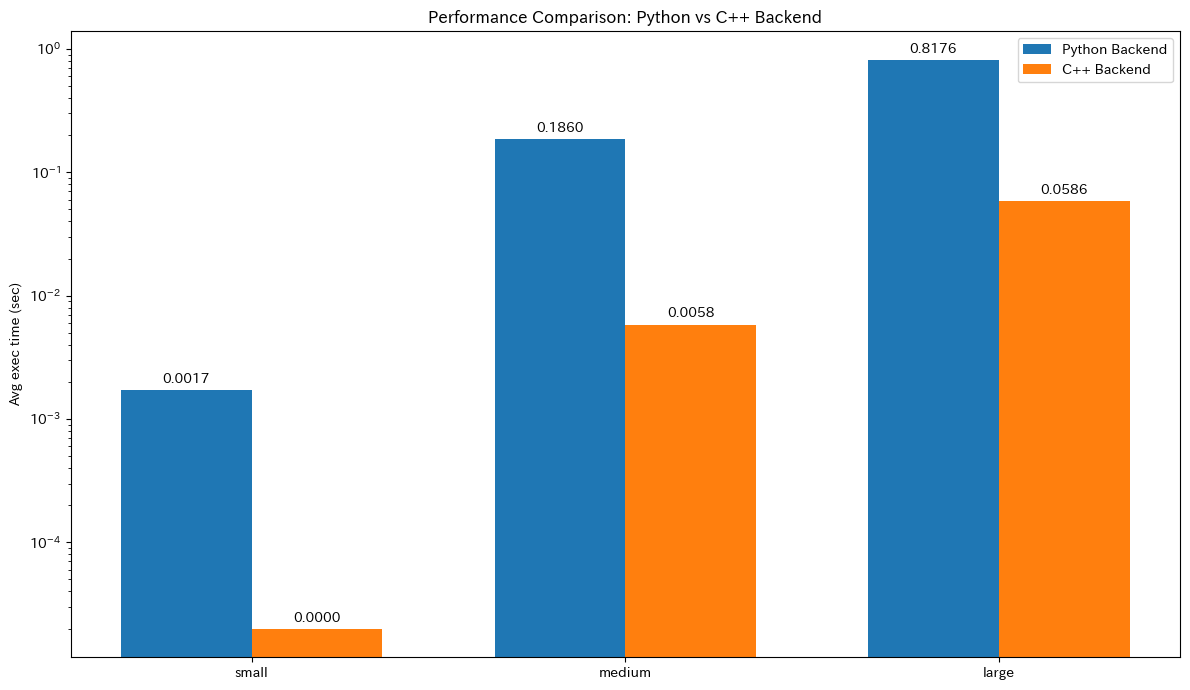

In [4]:
labels = list(results_single.keys())
python_times = [r["Python (s)"] for r in results_single.values()]
cpp_times = [r["C++ (s)"] for r in results_single.values()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, python_times, width, label="Python Backend")
rects2 = ax.bar(x + width / 2, cpp_times, width, label="C++ Backend")

ax.set_ylabel("Avg exec time (sec)")
ax.set_title("Performance Comparison: Python vs C++ Backend")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yscale("log")  # 時間差が大きいので対数スケール
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.4f")
ax.bar_label(rects2, padding=3, fmt="%.4f")

fig.tight_layout()
plt.show()

## 4. ベンチマーク2: 行列計算のパフォーマンス

複数のシーケンスからなるリスト全体の距離行列を計算する際のパフォーマンスを比較します。

### `cped_matrix` のパフォーマンス

In [5]:
# 行列計算用のシーケンスリストを生成
num_sequences = 20
sequences = [generate_test_case(10, 10, 3)[1] for _ in range(num_sequences)]
print(f"{num_sequences}本のシーケンスを生成しました。 (各 約{len(sequences[0])}文字)")

20本のシーケンスを生成しました。 (各 約110文字)


In [6]:
results_matrix = {}

# 1. Pythonバックエンド
start_time = timeit.default_timer()
matrix_py = cped_matrix(sequences, backend="python")
results_matrix["Python Backend"] = timeit.default_timer() - start_time

# 2. C++バックエンド
time_cpp_matrix = 0
if CPP_AVAILABLE:
    start_time = timeit.default_timer()
    matrix_cpp = cped_matrix(sequences, backend="cpp")
    time_cpp_matrix = timeit.default_timer() - start_time
results_matrix["C++ Backend"] = time_cpp_matrix

print("--- Total Execution Time for Matrix Calculation ---")
for name, duration in results_matrix.items():
    print(f"{name}: {duration:.4f}s")

--- Total Execution Time for Matrix Calculation ---
Python Backend: 43.6946s
C++ Backend: 0.4580s


### `bicped_matrix` のパフォーマンス

In [7]:
results_matrix_bicped = {}

# 1. Python
start_time = timeit.default_timer()
matrix_py_bicped = bicped_matrix(sequences, backend="python")
results_matrix_bicped["Python"] = timeit.default_timer() - start_time

# 2. C++ (逐次)
time_cpp_seq = 0
if CPP_AVAILABLE:
    start_time = timeit.default_timer()
    matrix_cpp_seq_bicped = bicped_matrix(sequences, backend="cpp", parallel=False)
    time_cpp_seq = timeit.default_timer() - start_time
results_matrix_bicped["C++ (Sequential)"] = time_cpp_seq

# 3. C++ (並列)
time_cpp_par = 0
if CPP_AVAILABLE:
    start_time = timeit.default_timer()
    matrix_cpp_par_bicped = bicped_matrix(sequences, backend="cpp", parallel=True)
    time_cpp_par = timeit.default_timer() - start_time
results_matrix_bicped["C++ (Parallel)"] = time_cpp_par

print("--- bicped_matrix: Total Execution Time ---")
for name, duration in results_matrix_bicped.items():
    print(f"{name}: {duration:.4f}s")

--- bicped_matrix: Total Execution Time ---
Python: 84.4632s
C++ (Sequential): 3.7913s
C++ (Parallel): 1.0039s


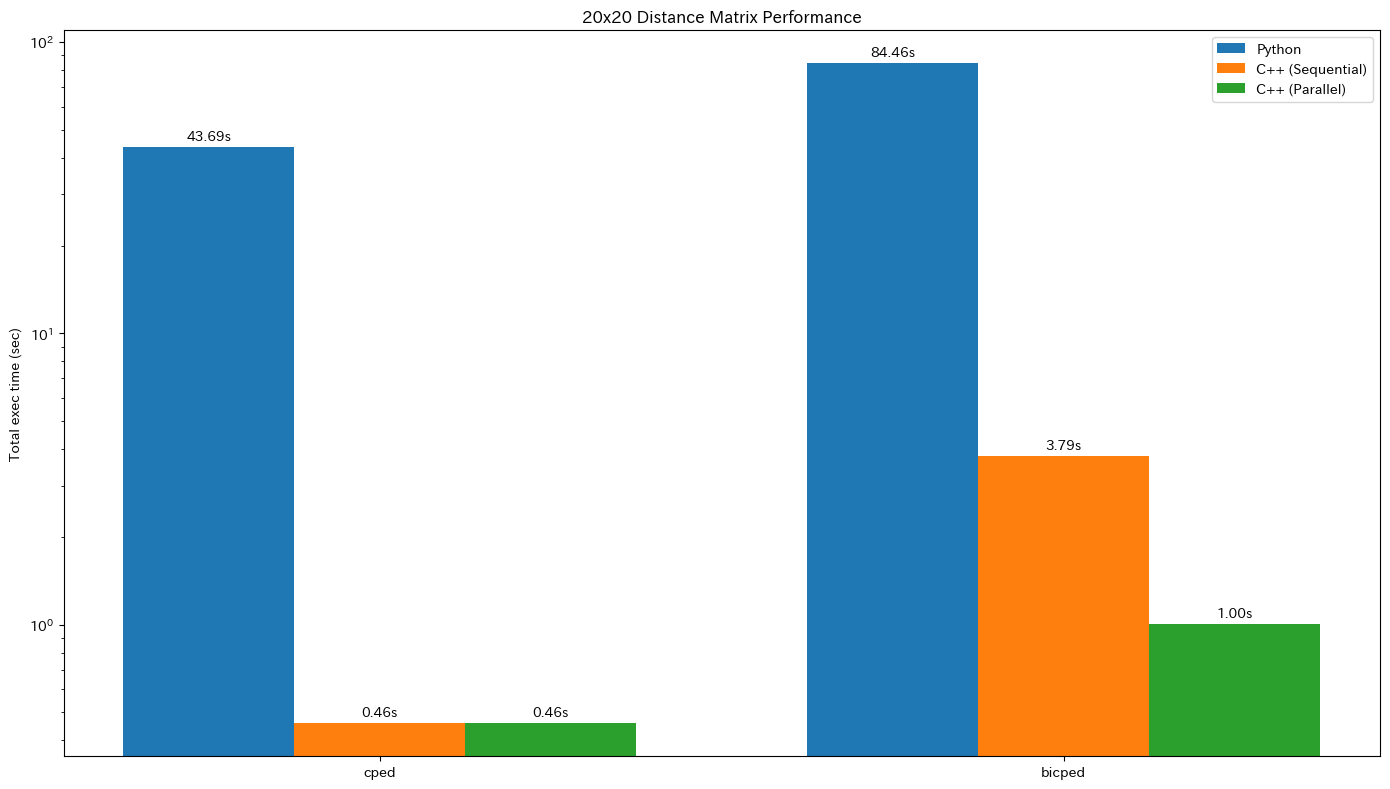

In [8]:
all_labels = ['cped', 'bicped']
python_times = [
    results_matrix.get('Python Backend', 0),
    results_matrix_bicped.get('Python', 0)
]
cpp_seq_times = [
    results_matrix.get('C++ Backend', 0), # cped only has one C++ time
    results_matrix_bicped.get('C++ (Sequential)', 0)
]
cpp_par_times = [
    results_matrix.get('C++ Backend', 0), # Assuming parallel for cped
    results_matrix_bicped.get('C++ (Parallel)', 0)
]

x = np.arange(len(all_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, python_times, width, label='Python')
rects2 = ax.bar(x, cpp_seq_times, width, label='C++ (Sequential)')
rects3 = ax.bar(x + width, cpp_par_times, width, label='C++ (Parallel)')

ax.set_ylabel('Total exec time (sec)')
ax.set_title(f'{num_sequences}x{num_sequences} Distance Matrix Performance')
ax.set_xticks(x)
ax.set_xticklabels(all_labels)
ax.set_yscale('log')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2fs')
ax.bar_label(rects2, padding=3, fmt='%.2fs')
ax.bar_label(rects3, padding=3, fmt='%.2fs')

fig.tight_layout()
plt.show()

## 5. 結論

ベンチマークの結果から、以下のことが分かります。

1.  **C++は非常に効果的**: 1対1の計算と行列計算の両方において、C++バックエンドはPythonバックエンドに比べて劇的に高速です。文字列が長くなるほど、その差は顕著になります。
2.  **並列化はC++実装で**: C++実装は内部でネイティブスレッドを利用して並列化されており、大規模な行列計算で非常に高いパフォーマンスを発揮します。

したがって、パフォーマンスが重要視される場面では、C++バックエンド（`backend='cpp'`）を積極的に使用することが推奨されます。

### ベンチマーク1-B: `bicped` の1対1パフォーマンス

In [9]:
results_bicped_single = {}
number_of_runs = 20

for name, (X, Y) in test_cases.items():
    # Python版
    time_py = timeit.timeit(lambda: bicped(X, Y, backend="python"), number=number_of_runs)

    # C++版
    time_cpp = 0
    if CPP_AVAILABLE:
        bicped(X, Y, backend="cpp") # Warm-up
        time_cpp = timeit.timeit(lambda: bicped(X, Y, backend="cpp"), number=number_of_runs)
    
    results_bicped_single[name] = {
        "Python (s)": time_py / number_of_runs,
        "C++ (s)": time_cpp / number_of_runs if CPP_AVAILABLE else 0,
    }

print("--- bicped: Average Execution Time per Run ---")
for name, times in results_bicped_single.items():
    print(f"Case '{name}': Python={times['Python (s)']:.6f}s, C++={times['C++ (s)']:.6f}s")

--- bicped: Average Execution Time per Run ---
Case 'small': Python=0.003650s, C++=0.000054s
Case 'medium': Python=0.256046s, C++=0.012790s
Case 'large': Python=1.577179s, C++=0.128346s


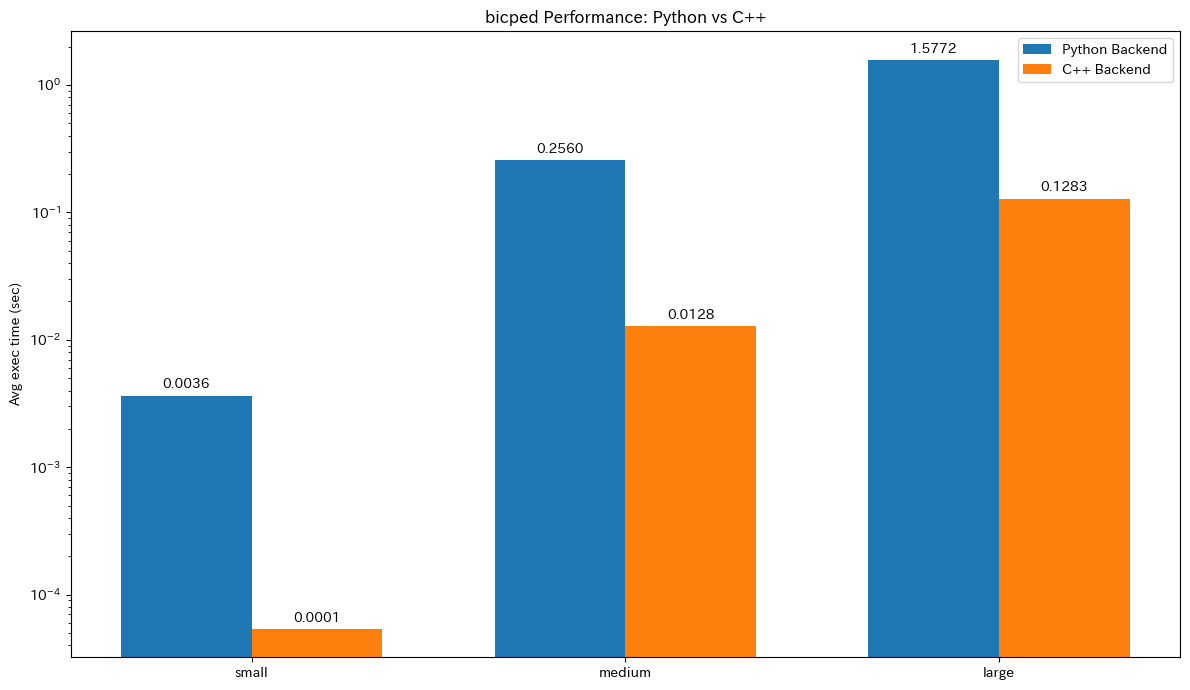

In [10]:
labels_bicped = list(results_bicped_single.keys())
python_times_bicped = [r["Python (s)"] for r in results_bicped_single.values()]
cpp_times_bicped = [r["C++ (s)"] for r in results_bicped_single.values()]

x = np.arange(len(labels_bicped))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, python_times_bicped, width, label="Python Backend")
rects2 = ax.bar(x + width / 2, cpp_times_bicped, width, label="C++ Backend")

ax.set_ylabel("Avg exec time (sec)")
ax.set_title("bicped Performance: Python vs C++")
ax.set_xticks(x)
ax.set_xticklabels(labels_bicped)
ax.set_yscale("log")
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.4f")
ax.bar_label(rects2, padding=3, fmt="%.4f")

fig.tight_layout()
plt.show()